Keras Doc: [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

**Keras Documentation에서 이상한 점**
1. Augmentation이 Test set에도 적용
2. CLS token 없음
3. transformer의 FeedForward와 MLP header를 동인한 파라미터로 사용

**이번 예제에서 배운 점**
1. [einops](https://github.com/arogozhnikov/einops)나 einsum이 굉장히 많이 활용되고 있음
2. google도 이젠 tensorflow 말고 [flax](https://github.com/google/flax) 사용 많이 하는 듯 
3. pytorch의 chunk function
4. activation function으로 ReLU에에 GELU로 대체되고 있다

# ViT (Vision Transform)

- Paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)


![](https://github.com/lucidrains/vit-pytorch/raw/main/images/vit.gif)

![image](https://user-images.githubusercontent.com/37654013/124294454-ad0dc100-db92-11eb-8056-08f3c9f9cd21.png)

![image](https://user-images.githubusercontent.com/37654013/124294795-1097ee80-db93-11eb-9656-faff0ebb4272.png)

In [1]:
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import json

from einops.layers.torch import Rearrange
from einops import rearrange, repeat

from torch import einsum

In [2]:
class Config:
    datadir            = '../data'
    image_size         = 72
    patch_size         = 6
    seed               = 223
    epochs             = 100
    batch_size         = 16
    accumulation_steps = 16
    depth              = 12
    dim                = 768 
    mlp_dim            = 3072
    heads              = 12
    dropout            = 0.1
    emb_dropout        = 0.1
    lr                 = 0.001
    num_classes        = 100
    num_workers        = 8
    gpu_num            = 0

In [3]:
config = Config()

In [4]:
device = f'cuda:{config.gpu_num}' if torch.cuda.is_available() else 'cpu'

# Load CIFAR100

In [5]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((config.image_size,)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=0.02),
    torchvision.transforms.RandomResizedCrop(size=(config.image_size,), scale=(0.8,1), ratio=(1,1.)),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((config.image_size,)),
])

In [6]:
trainset = torchvision.datasets.CIFAR100(root=config.datadir, 
                                         train=True, 
                                         download=True,
                                         transform=transform_train)
testset = torchvision.datasets.CIFAR100(root=config.datadir, 
                                        train=False, 
                                        download=True,
                                        transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=config.batch_size, 
                                          shuffle=True, 
                                          num_workers=config.num_workers)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=config.batch_size, 
                                         shuffle=True, 
                                         num_workers=config.num_workers)

Files already downloaded and verified
Files already downloaded and verified


## visualization

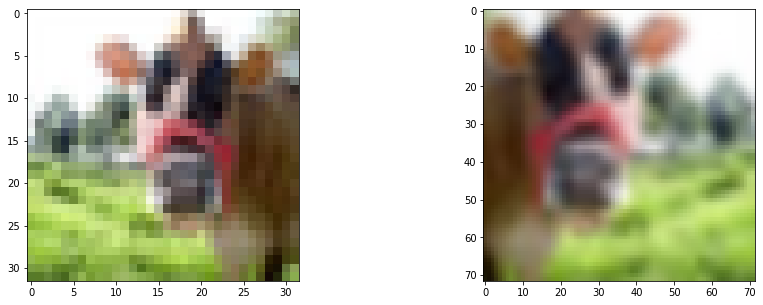

In [7]:
trans_img = trainset.transform(trainset.data[0])

f, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(trainset.data[0])
ax[1].imshow(np.transpose(trans_img, axes=(1,2,0)))

**einops**

![](https://user-images.githubusercontent.com/6318811/116849688-0ca41c00-aba4-11eb-8ccf-74744f6cbc23.mp4)

In [8]:
temp = Rearrange('c (h p1) (w p2) -> (h w) (p1 p2 c)', p1=config.patch_size ,p2=config.patch_size)

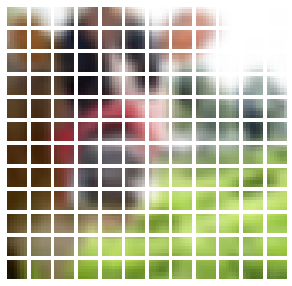

In [9]:
num_row = config.image_size//config.patch_size
num_col = config.image_size//config.patch_size
f, ax = plt.subplots(num_row, num_col, 
                     figsize=(5,5))

for i, patch_i in enumerate(temp(trans_img)):
    ax[i//num_row, i%num_col].imshow(patch_i.numpy().reshape(config.patch_size,config.patch_size,3))
    ax[i//num_row, i%num_col].axis('off')

# Build Model

- ViT Source Code: https://github.com/lucidrains/vit-pytorch/blob/64a2ef6462bde61db4dd8f0887ee71192b273692/vit_pytorch/vit.py#L10

![image](https://user-images.githubusercontent.com/37654013/124264038-f815dd00-db6e-11eb-8042-a120e820a823.png)

## PreNorm

In [10]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
        
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

## FeedForward

GELU paper: [GAUSSIAN ERROR LINEAR UNITS (GELUS)](https://arxiv.org/pdf/1606.08415.pdf)

![image](https://user-images.githubusercontent.com/37654013/124347836-93678a80-dc21-11eb-9bdb-a79d53144fd5.png)

![image](https://user-images.githubusercontent.com/37654013/124347849-a4b09700-dc21-11eb-86f3-9214fb9d7785.png)

In [11]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)

## Attention 

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not(heads == 1 and dim_head == dim)
        
        self.heads = heads
        self.scale = dim_head ** -0.5
        
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
        
    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        
        attn = self.attend(dots)
        
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        
        return self.to_out(out)

In [13]:
b, n, h = 2, 4, 5
dim, dim_head = 4, 2

to_qkv = nn.Linear(dim, (dim_head*h) * 3, bias = False)

x = torch.randn(b,n,dim)

out = to_qkv(x)
print('out.size(): ',out.size())

qkv = out.chunk(3, dim=-1)

print('len(qkv): ',len(qkv))
print('qkv[0].size(): ',qkv[0].size())

q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

print('q.size(): ',q.size())

out.size():  torch.Size([2, 4, 30])
len(qkv):  3
qkv[0].size():  torch.Size([2, 4, 10])
q.size():  torch.Size([2, 5, 4, 2])


## Transformer

In [14]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
            
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
            
        return x        

## ViT

In [15]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)


class ViT(nn.Module):
    def __init__(
        self, *, 
        image_size, 
        patch_size, 
        num_classes, 
        dim, 
        depth, 
        heads, 
        mlp_dim, 
        pool = 'cls', 
        channels = 3, 
        dim_head = 64, 
        dropout = 0., 
        emb_dropout = 0.):
    
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        
        assert image_height % patch_height == 0 and image_width % patch_width == 0, \
                'Image dimensions must be divisible by the patch size.'
        
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim)
        )
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        
        self.pool = pool
        self.to_latent = nn.Identity()
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        
    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n+1)]
        x = self.dropout(x)
        
        x = self.transformer(x)
        
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]
        
        x = self.to_latent(x)
        return self.mlp_head(x)

In [16]:
model = ViT(image_size  = config.image_size,
            patch_size  = config.patch_size,
            num_classes = config.num_classes,
            dim         = config.dim,
            heads       = config.heads,
            depth       = config.depth,
            mlp_dim     = config.mlp_dim,
            dim_head    = int(config.dim / config.heads),
            dropout     = config.dropout,
            emb_dropout = config.emb_dropout).to(device)

In [17]:
num_params = np.sum([np.prod(p.size()) for p in model.parameters()])
print('Number of ViT parameters: ',num_params)

Number of ViT parameters:  85301092


# Train

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
def train(
    model, dataloader, criterion, optimizer, accumulation_steps, device='cpu'
):
    correct = 0 
    total = 0
    total_loss = 0
    
    optimizer.zero_grad()
    for idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # predict
        outputs = model(inputs)
            
        # loss and update
        loss = criterion(outputs, targets)
        (loss / accumulation_steps).backward()
        
        if (idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # total loss and acc
        total_loss += loss.item()
        
        preds = outputs.argmax(dim=1) 
        correct += targets.eq(preds).sum().item()
        total += targets.size(0)
        
        if idx == (len(dataloader)-1):
            print('[%d/%d]: Loss: %.3f | Acc: %.3f%% [%d/%d]' % 
                  (idx+1, len(dataloader), total_loss/(idx+1), 100.*correct/total, correct, total),end='\n')
        else:
            print('[%d/%d]: Loss: %.3f | Acc: %.3f%% [%d/%d]' % 
                  (idx+1, len(dataloader), total_loss/(idx+1), 100.*correct/total, correct, total),end='\r')
        
    return 100.*correct/total, total_loss/len(dataloader)
        
def test(model, dataloader, criterion, device='cpu'):
    correct = 0
    correct_top5 = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # predict
            outputs = model(inputs)
            
            # loss 
            loss = criterion(outputs, targets)
            
            # total loss and acc
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            _, preds_top5 = outputs.topk(5, dim=1)
            
            correct += targets.eq(preds).sum().item()
            correct_top5 += preds_top5.eq(targets.view(-1, 1).expand_as(preds_top5)).sum().item()
            total += targets.size(0)
                        
            if idx == (len(dataloader)-1):
                print('[%d/%d]: Loss: %.3f | Top-1 Acc: %.3f%% [%d/%d] | Top-5 Acc: %.3f%% [%d/%d]' % 
                      (idx+1, len(dataloader), total_loss/(idx+1), 
                       100.*correct/total, correct, total,
                       100.*correct_top5/total, correct_top5, total),end='\n')
            else:
                print('[%d/%d]: Loss: %.3f | Top-1 Acc: %.3f%% [%d/%d] | Top-5 Acc: %.3f%% [%d/%d]' % 
                      (idx+1, len(dataloader), total_loss/(idx+1), 
                       100.*correct/total, correct, total,
                       100.*correct_top5/total, correct_top5, total),end='\r')
                
        return 100.*correct/total, 100.*correct_top5/total, total_loss/len(dataloader)
            

In [20]:
# history
history = {
    'train':{
        'top1-acc':[],
        'loss':[]
    },
    'test':{
        'top1-acc':[],
        'top5-acc':[],
        'loss':[]
    }
}

for epoch in range(config.epochs):
    print(f'Epoch: {epoch+1}/{config.epochs}')
    train_top1acc, train_loss = train(model, trainloader, criterion, optimizer, config.accumulation_steps, device=device)
    test_top1acc, test_top5acc, test_loss = test(model, testloader, criterion, device)
    
    # history
    history['train']['top1-acc'].append(train_top1acc)
    history['train']['loss'].append(train_loss)
    history['test']['top1-acc'].append(test_top1acc)
    history['test']['top5-acc'].append(test_top5acc)
    history['test']['loss'].append(test_loss)

Epoch: 1/100
[3125/3125]: Loss: 4.557 | Acc: 2.318% [1159/50000]
[625/625]: Loss: 4.167 | Top-1 Acc: 5.850% [585/10000] | Top-5 Acc: 20.940% [2094/10000]
Epoch: 2/100
[3125/3125]: Loss: 3.944 | Acc: 8.934% [4467/50000]
[625/625]: Loss: 3.799 | Top-1 Acc: 11.630% [1163/10000] | Top-5 Acc: 33.590% [3359/10000]
Epoch: 3/100
[3125/3125]: Loss: 3.693 | Acc: 12.918% [6459/50000]
[625/625]: Loss: 3.636 | Top-1 Acc: 14.130% [1413/10000] | Top-5 Acc: 38.300% [3830/10000]
Epoch: 4/100
[3125/3125]: Loss: 3.572 | Acc: 14.824% [7412/50000]
[625/625]: Loss: 3.534 | Top-1 Acc: 15.570% [1557/10000] | Top-5 Acc: 41.010% [4101/10000]
Epoch: 5/100
[3125/3125]: Loss: 3.483 | Acc: 16.488% [8244/50000]
[625/625]: Loss: 3.498 | Top-1 Acc: 15.360% [1536/10000] | Top-5 Acc: 42.050% [4205/10000]
Epoch: 6/100
[3125/3125]: Loss: 3.444 | Acc: 17.102% [8551/50000]
[625/625]: Loss: 3.435 | Top-1 Acc: 17.720% [1772/10000] | Top-5 Acc: 43.400% [4340/10000]
Epoch: 7/100
[3125/3125]: Loss: 3.425 | Acc: 17.556% [8778/500

In [21]:
# save model
weights = {'model':model.state_dict()}
torch.save(weights, 'ViT_CIFAR100.pt')

In [30]:
json.dump(history,open('ViT_CIFAR100.json','w'),indent=4)

# History

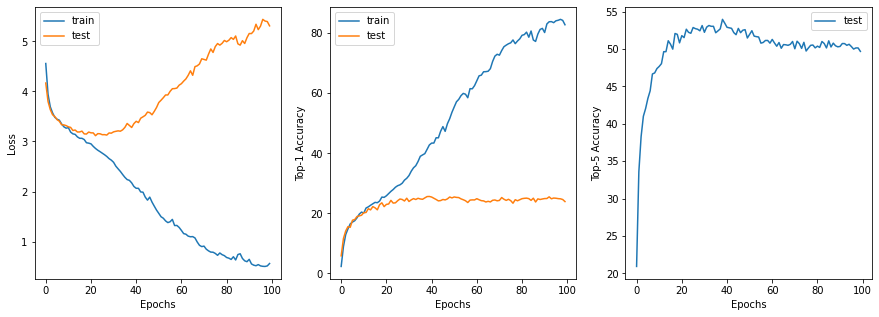

In [28]:
f, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].plot(np.arange(len(history['train']['loss'])), history['train']['loss'])
ax[0].plot(np.arange(len(history['test']['loss'])), history['test']['loss'])
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(['train','test'])
ax[1].plot(np.arange(len(history['train']['top1-acc'])), history['train']['top1-acc'])
ax[1].plot(np.arange(len(history['test']['top1-acc'])), history['test']['top1-acc'])
ax[1].set_ylabel('Top-1 Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train','test'])
ax[2].plot(np.arange(len(history['test']['top5-acc'])), history['test']['top5-acc'])
ax[2].set_ylabel('Top-5 Accuracy')
ax[2].set_xlabel('Epochs')
ax[2].legend(['test'])

# Visualize Position Embedding

![image](https://user-images.githubusercontent.com/37654013/124371571-fc044500-dcbd-11eb-9da0-3e2f26540e08.png)


In [97]:
def cos_sim(a, b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

pos_embed = model.pos_embedding[:,1:,:].squeeze().cpu().detach().numpy()

pos_sim = np.zeros((pos_embed.shape[0], pos_embed.shape[0]))

for i in range(pos_embed.shape[0]):
    for j in range(pos_embed.shape[0]):
        pos_sim[i,j] = cos_sim(pos_embed[i], pos_embed[j])

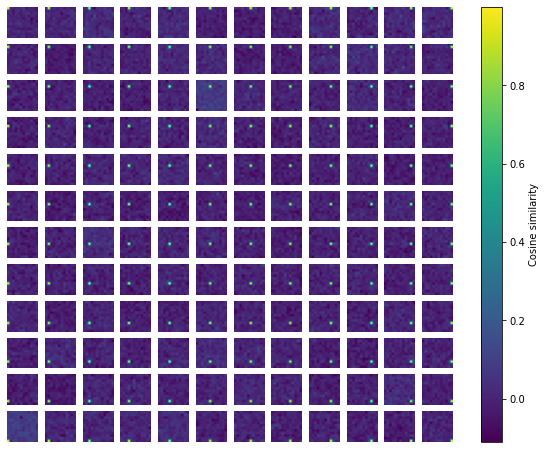

In [99]:
num_row, num_col = [config.image_size // config.patch_size] * 2
f, axes = plt.subplots(num_row, num_col, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(pos_sim[i].reshape(num_row, num_col))
    ax.axis('off')

cbar = plt.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label('Cosine similarity')